In [1]:
import tensorflow as tf
print(tf.__version__)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

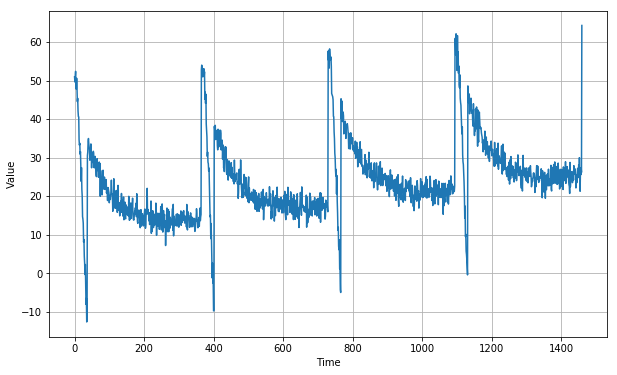

In [11]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Split

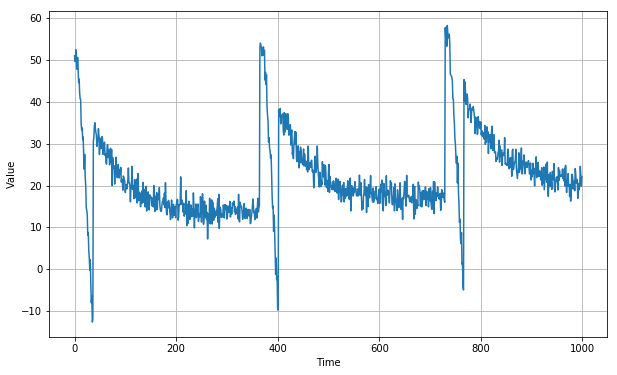

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

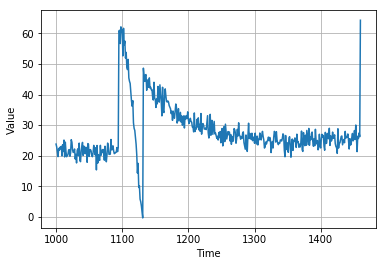

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Naive Forecast

In [15]:
naive_forecast = series[split_time - 1: -1]

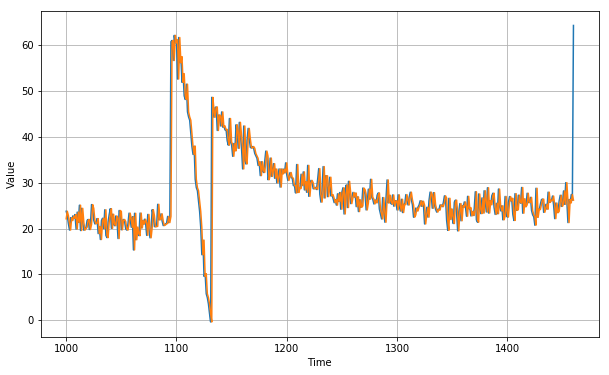

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

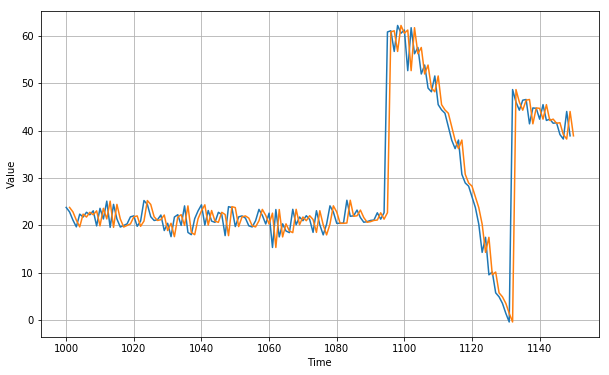

In [19]:
### Zoom in on validation period
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [21]:
### Mean squared error
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

20.158268
2.5868616


### Seasonality reductions
- Remove the seasonality by differencing  
- Seasonality period is 365 days . 
- Subtract the value at time t - 365 from the value at time t

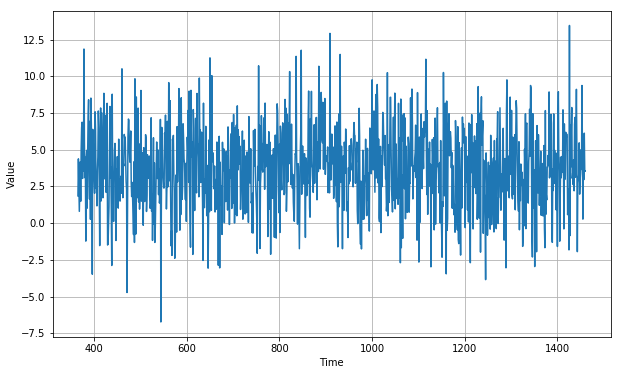

In [22]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

In [24]:
def moving_average_forecast(series, window_size):
    """
    Forecasts the mean of the last few values.
    If window_size = 1, then this is equivalent to naive forecast
    """
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

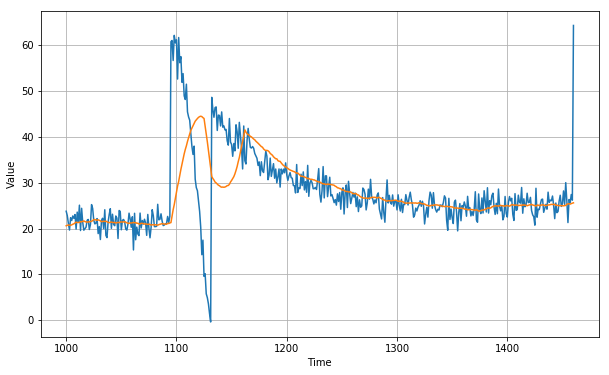

In [26]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

### Reduce Trend and the Seasonality

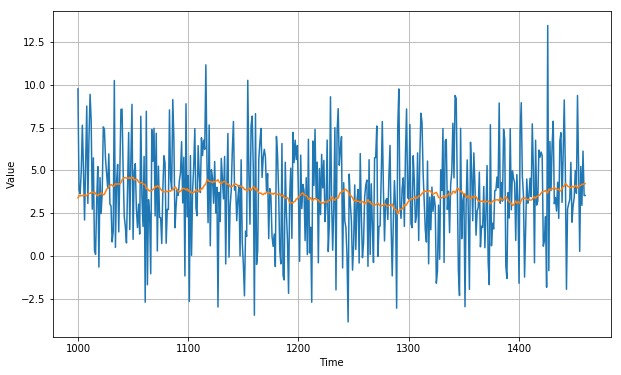

In [25]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])

plot_series(time_valid, diff_moving_avg)
plt.show()

### Get trend and seasonality back

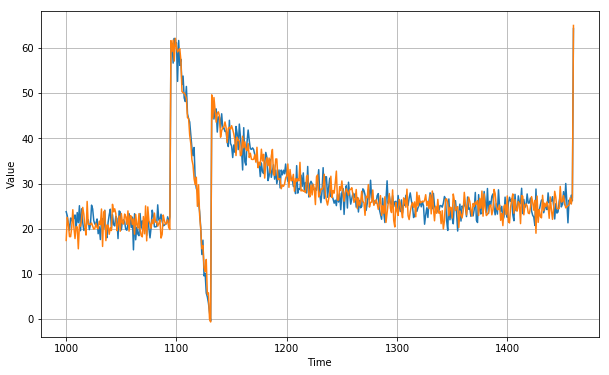

In [28]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [29]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

8.475784
2.3357244


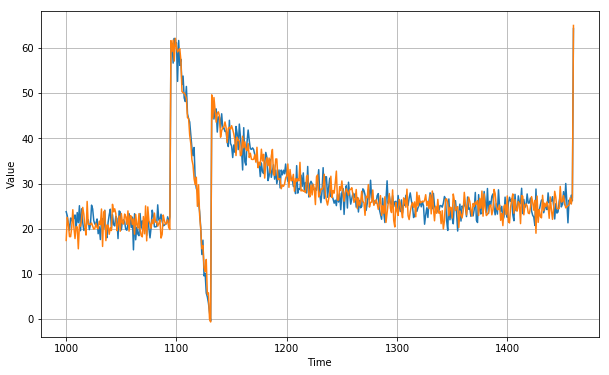

In [30]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [31]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

8.475784
2.3357244
